In [ ]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [ ]:
cleansed=load_amihud_markets_price()

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [ ]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

# Academic papers
Based on Illin, A., Raiko, T. 2010 paper called "Practical Approaches to Principal Component Analysis in the Presence of Missing Values"

Tipping and Bishop (1999) introducted probablistic formulation of PCA (PPCA)


Use a flavor of Probabilistic PCA that is robust to missing data (see Ilin and Raiko 2010). Rather than the vanilla one-shot SVD, PPCA uses an iterative EM procedure/fixed point algorithm. From an initial guess, it’ll alternatively interpolate missing data and update the components until convergence.

On a side note, PPCA interpolates using information from all series, making it a multivariate interpolator. Be careful though, fitting the model to too many components will likely lead to overfitting problems in the interpolated data.

Also note that I am using the standardization that is mentioned in Korajecyk and Sadka (2008) of expanding zscores


In [ ]:
data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
#data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

In [ ]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [ ]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i+1]=x
        sector_PC[sect] = pcs
    except:
        print sect

In [ ]:
df=pd.DataFrame()
for k in sector_PC.keys():
    df[k]=sector_PC[k].mean(axis=1)
    

In [ ]:
df.plot(subplots=True)

In [ ]:
sector_PC.keys()

In [ ]:
f, a = plt.subplots(len(sector_PC.keys())-1,1,sharex=True)
i=0
for k in sector_PC.keys():
    if k == 'Currencies':
        continue
    sector_PC[k].plot(ax=a[i],title=k,legend=False)
    i=i+1

a[4].legend(handles = a[4] , labels=['A', 'B', 'C'],loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=False, ncol=3)


In [ ]:
liq=liquidity_observables()
market_liquidity=liq[1]
funding_liquidity=liq[0]

In [ ]:
all_factors=pd.DataFrame()
for s in sector_PC.keys():
    for i in range(1,4):
        all_factors[s + ' '+str(i)]=sector_PC[s][i]

In [ ]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in all_factors.columns:
        ind=all_factors[s].index
        res=sm.OLS(all_factors[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [ ]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in all_factors.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=all_factors[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(all_factors[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(all_factors.columns)

In [ ]:
results_df.T.round(2)

In [ ]:
print results_df.T.round(2).to_latex()

# FHT method

In [18]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:398: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:399: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:400: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:400: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [19]:
data=calc_zscore_ew(FHT.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:392: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=12,adjust=True,com=3).mean()
  return (df-pd.ewma(df,lookback,min_periods=12))/pd.ewmstd(df,lookback,min_periods=12)
tsmom_model.py:392: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=12,adjust=True,com=3).std(bias=False)
  return (df-pd.ewma(df,lookback,min_periods=12))/pd.ewmstd(df,lookback,min_periods=12)


In [24]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')['2000':'2016']

In [25]:
sector_PC_FHT={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i+1]=x
        sector_PC_FHT[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


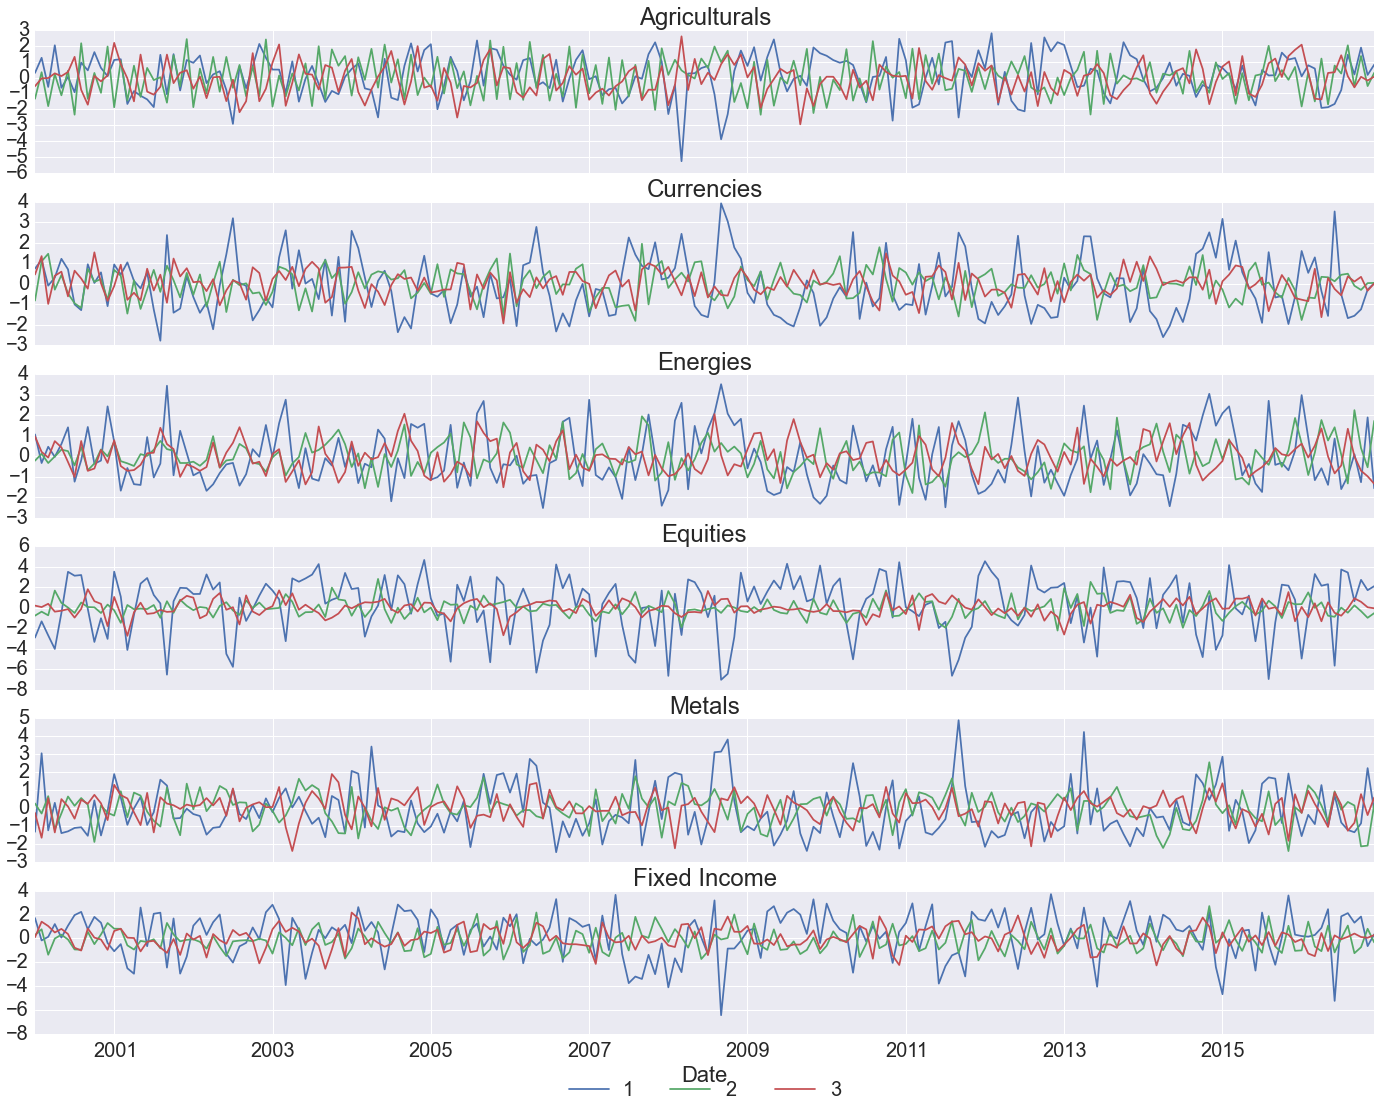

In [26]:
f, a = plt.subplots(len(sector_PC_FHT.keys()),1,sharex=True)
i=0
for k in sector_PC.keys():
    sector_PC_FHT[k]['2000':'2016'].plot(ax=a[i],title=k,legend=False)
    i=i+1

a[5].legend(handles = a[5] , labels=['A', 'B', 'C'],loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=False, ncol=3)

# Loading liquidity observables

In [34]:
all_factors=pd.DataFrame()
for s in sector_PC.keys():
    for i in range(1,4):
        all_factors[s + ' '+str(i)]=sector_PC[s][i]
        

In [74]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in all_factors.columns:
        ind=all_factors[s].index
        res=sm.OLS(all_factors[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [75]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in all_factors.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=all_factors[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(all_factors[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(all_factors.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [76]:
results_df.T.round(2)

,Agriculturals 1,Agriculturals 2,Agriculturals 3,Currencies 1,Currencies 2,Currencies 3,Energies 1,Energies 2,Energies 3,Equities 1,Equities 2,Equities 3,Metals 1,Metals 2,Metals 3,Fixed Income 1,Fixed Income 2,Fixed Income 3
PS,-5.57,-1.27,-2.28,9.25,-1.27,-0.75,0.43,0.76,1.27,-9.10,4.50,1.02,4.17,-2.03,2.48,6.95,-3.00,-0.67
PSTstats,-1.90,-0.68,-1.89,2.83,-1.18,-0.68,0.24,0.80,1.32,-2.73,2.00,1.15,1.46,-1.67,2.22,2.19,-2.15,-0.64
On versus off the run Treasuries,6.19,1.68,0.09,-5.08,-1.59,0.70,0.85,-0.35,-0.12,6.37,-0.08,-2.33,-5.95,-0.63,0.12,-6.23,0.23,1.12
On versus off the run TreasuriesTstats,5.34,1.51,0.13,-4.04,-2.74,1.89,0.86,-0.79,-0.24,4.20,-0.07,-5.37,-5.49,-0.99,0.18,-6.53,0.36,1.65
TED Spread,115.05,-27.06,89.00,-253.92,1.31,48.42,-15.27,-14.42,2.30,163.02,-209.20,0.97,-129.01,89.43,-60.12,-216.79,93.56,-52.90
TED SpreadTstats,1.93,-0.74,7.40,-5.47,0.09,4.16,-0.55,-1.23,0.19,2.87,-9.69,0.05,-2.18,5.92,-3.46,-5.78,5.46,-4.58
LIBOR term repo,-6.16,-2.70,-32.97,109.64,-0.18,-34.16,48.76,5.74,-0.24,-45.58,107.22,21.12,55.42,-50.63,11.10,112.43,-72.84,1.83
LIBOR term repoTstats,-0.17,-0.13,-4.83,4.24,-0.02,-2.74,1.84,0.82,-0.03,-2.28,3.91,3.26,2.06,-3.60,1.11,6.64,-3.77,0.36


In [ ]:
print results_df.T.round(2).to_latex()